<a href="https://colab.research.google.com/github/ktsim01/FIFA-World-Cup-2022-Prediction/blob/main/World_Cup_2022_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
#Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.ticker as plticker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [57]:
results = pd.read_csv('results.csv')

In [58]:
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


Create new columns showing who won and the goal differences

In [59]:
winner = []
for i in range (len(results['home_team'])):
    if results ['home_score'][i] > results['away_score'][i]:
        winner.append(results['home_team'][i])
    elif results['home_score'][i] < results ['away_score'][i]:
        winner.append(results['away_team'][i])
    else:
        winner.append('Draw')
results['winning_team'] = winner

#adding goal difference column
results['goal_difference'] = np.absolute(results['home_score'] - results['away_score'])

results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,winning_team,goal_difference
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,Draw,0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,England,2
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,Scotland,1
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,Draw,0
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,Scotland,3


Checking what the data looks like with a box plot.

([<matplotlib.axis.XTick at 0x7f24b0ccedd0>,
 [Text(0, 0, 'Home Score'), Text(0, 0, 'Away Score')])

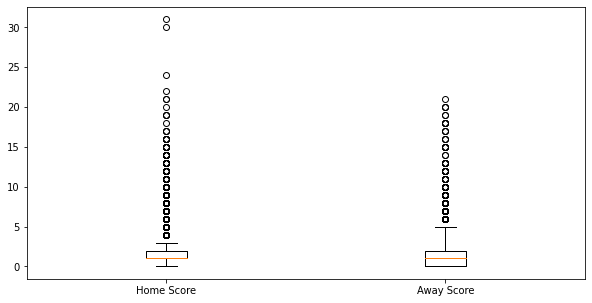

In [60]:
fig = plt.figure(figsize =(10, 5))
plt.boxplot([results["home_score"],results["away_score"]])
plt.xticks([1,2], ["Home Score", "Away Score"])

Let's remove all the outliers so as to make the model more accurate

In [61]:
goal_max=15 #Maximum goals one team can score is limited to 15
results=results[(results["home_score"]<goal_max) & (results["away_score"]<goal_max)]
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,winning_team,goal_difference
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,Draw,0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,England,2
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,Scotland,1
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,Draw,0
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,Scotland,3


Group Stage for the Qatar World Cup 2022:

**Group A**: Qatar, Ecuador, Senegal, Netherlands 

**Group B**: England, Iran, USA, Wales 

**Group C**: Argentina, Saudi Arabia, Mexico, Poland 

**Group D**: France, Denmark, Tunisia, Australia 

**Group E**: Spain, Germany, Japan , Costa Rica

**Group F**: Belgium, Canada, Morocco, Croatia 

**Group G**: Brazil, Serbia, Switzerland, Cameroon 

**Group H**: Portugal, Ghana, Uruguay, South Korea

From here, we will filter the data to the selected teams and only use data after 1930. In addition, irrelevant data will be dropped

In [62]:
worldcup_teams = ['Qatar', 'Ecuador', 'Senegal', 'Netherlands',
                  'England', 'Iran', 'USA', 'Wales',
                  'Argentina', 'Saudi Arabia', 'Mexico', 'Poland',
                  'France', 'Denmark', 'Tunisia', 'Australia',
                  'Spain', 'Germany', 'Japan', 'Costa Rica',
                  'Belgium', 'Canada', 'Morocco', 'Croatia',
                  'Brazil', 'Serbia', 'Switzerland', 'Cameroon',
                  'Portugal', 'Ghana', 'Uruguay', 'South Korea']

df_teams_home = results[results['home_team'].isin(worldcup_teams)]
df_teams_away = results[results['away_team'].isin(worldcup_teams)]
df_teams = pd.concat((df_teams_home, df_teams_away))
df_teams.drop_duplicates()
df_teams.count()

year = []
for row in df_teams['date']:
    year.append(int(row[:4]))
df_teams['match_year'] = year
df_teams_1930 = df_teams[df_teams.match_year >= 1930]
df_teams_1930.head()

df_teams_1930 = df_teams.drop(['date', 'home_score', 'away_score', 'tournament', 'city', 'country',
                               'goal_difference', 'match_year', 'neutral'], axis = 1)

df_teams_1930.head()

,home_team,away_team,winning_team
1,England,Scotland,England
3,England,Scotland,Draw
6,England,Scotland,Scotland
7,Wales,Scotland,Scotland
10,England,Wales,England


Establishing prediction label to build our model

In [63]:
df_teams_1930 = df_teams_1930.reset_index(drop=True)
df_teams_1930.loc[df_teams_1930.winning_team == df_teams_1930.home_team,'winning_team']=2
df_teams_1930.loc[df_teams_1930.winning_team == 'Draw', 'winning_team']=1
df_teams_1930.loc[df_teams_1930.winning_team == df_teams_1930.away_team, 'winning_team']=0

df_teams_1930.head()

,home_team,away_team,winning_team
0,England,Scotland,2
1,England,Scotland,1
2,England,Scotland,0
3,Wales,Scotland,0
4,England,Wales,2


Now, we will convert the categorical variables into continuous variables.

In [64]:
final = pd.get_dummies(df_teams_1930, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

# Separate X and y sets
X = final.drop(['winning_team'], axis=1)
y = final["winning_team"]
y = y.astype('int')

# Separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [65]:
final.head()

,winning_team,home_team_Afghanistan,home_team_Albania,home_team_Algeria,home_team_Andalusia,home_team_Andorra,home_team_Angola,home_team_Argentina,home_team_Armenia,home_team_Aruba,...,away_team_Venezuela,away_team_Vietnam,away_team_Vietnam Republic,away_team_Wales,away_team_Western Australia,away_team_Yemen,away_team_Yemen DPR,away_team_Yugoslavia,away_team_Zambia,away_team_Zimbabwe
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


We will use Logistic Regression to create our machine learning model as it is fit for situations like this where we are trying to predict a binary outcome: win or loss.

In [66]:
final.head()
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
score = logreg.score(X_train, y_train)
score2 = logreg.score(X_test, y_test)

print('Training set accuracy ', '%.3f'%(score))
print('Test set accuracy ', '%.3f'%(score2))

Training set accuracy  0.569
Test set accuracy  0.572


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Incoporating the FIFA ranking as of June 2022 and the fixtures for the group stage, we will now deploy the machine learning model.

In [67]:
# Loading new datasets
fixtures = pd.read_csv('fixtures.csv')
ranking = pd.read_csv('fifa_rankings.csv', encoding = 'latin-1')

# List for storing the group stage games
pred_set = []

# Create new columns with ranking position of each team
fixtures.insert(1, 'first_position', fixtures['Home Team'].map(ranking.set_index('Team')['Position']))
fixtures.insert(2, 'second_position', fixtures['Away Team'].map(ranking.set_index('Team')['Position']))

# We only need the group stage games, so we have to slice the dataset
fixtures = fixtures.iloc[:48, :]
fixtures.tail()

,Match Number,first_position,second_position,Round Number,Date,Location,Home Team,Away Team,Group,Result
43,44,31.0,12.0,3,01/12/2022 19:00,Al Bayt Stadium,Costa Rica,Germany,Group E,NaN
44,45,60.0,13.0,3,02/12/2022 15:00,Al Janoub Stadium,Ghana,Uruguay,Group H,NaN
45,46,29.0,8.0,3,02/12/2022 15:00,Education City Stadium,South Korea,Portugal,Group H,NaN
46,47,25.0,14.0,3,02/12/2022 19:00,Stadium 974,Serbia,Switzerland,Group G,NaN
47,48,37.0,1.0,3,02/12/2022 19:00,Lusail Stadium,Cameroon,Brazil,Group G,NaN


In [68]:
# Loop to add teams to new prediction dataset based on the ranking position of each team
for index, row in fixtures.iterrows():
    if row['first_position'] < row['second_position']:
        pred_set.append({'home_team': row['Home Team'], 'away_team': row['Away Team'], 'winning_team': None})
    else:
        pred_set.append({'home_team': row['Away Team'], 'away_team': row['Home Team'], 'winning_team': None})
        
pred_set = pd.DataFrame(pred_set)
backup_pred_set = pred_set

pred_set.head()

,home_team,away_team,winning_team
0,Netherlands,Senegal,None
1,England,Iran,None
2,Ecuador,Qatar,None
3,USA,Wales,None
4,Argentina,Saudi Arabia,None


In [69]:
# Get dummy variables and drop winning_team column
pred_set = pd.get_dummies(pred_set, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

# Add missing columns compared to the model's training dataset
missing_cols = set(final.columns) - set(pred_set.columns)
for c in missing_cols:
    pred_set[c] = 0
pred_set = pred_set[final.columns]

# Remove winning team column
pred_set = pred_set.drop(['winning_team'], axis=1)

pred_set.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys


,home_team_Afghanistan,home_team_Albania,home_team_Algeria,home_team_Andalusia,home_team_Andorra,home_team_Angola,home_team_Argentina,home_team_Armenia,home_team_Aruba,home_team_Australia,...,away_team_Venezuela,away_team_Vietnam,away_team_Vietnam Republic,away_team_Wales,away_team_Western Australia,away_team_Yemen,away_team_Yemen DPR,away_team_Yugoslavia,away_team_Zambia,away_team_Zimbabwe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here are the predictions

In [76]:
#dictionary for results
results={}
for team in worldcup_teams:
  results[team]=0

#group matches 
predictions = logreg.predict(pred_set)
for i in range(fixtures.shape[0]):
    print(backup_pred_set.iloc[i, 0] + " and " + backup_pred_set.iloc[i, 1])
    if predictions[i] == 2:
        print("Winner: " + backup_pred_set.iloc[i, 0])
        results[backup_pred_set.iloc[i, 0]]+=2
    elif predictions[i] == 1:
        print("Draw")
        results[backup_pred_set.iloc[i, 0]]+=1
        results[backup_pred_set.iloc[i, 1]]+=1
    elif predictions[i] == 0:
        print("Winner: " + backup_pred_set.iloc[i, 1])
        results[backup_pred_set.iloc[i, 1]]+=2
    print('Probability of ' + backup_pred_set.iloc[i, 0] + ' winning: ', '%.3f'%(logreg.predict_proba(pred_set)[i][2]))
    print('Probability of Draw: ', '%.3f'%(logreg.predict_proba(pred_set)[i][1]))
    print('Probability of ' + backup_pred_set.iloc[i, 1] + ' winning: ', '%.3f'%(logreg.predict_proba(pred_set)[i][0]))
    print("")

Netherlands and Senegal
Winner: Netherlands
Probability of Netherlands winning:  0.639
Probability of Draw:  0.257
Probability of Senegal winning:  0.103

England and Iran
Winner: England
Probability of England winning:  0.621
Probability of Draw:  0.234
Probability of Iran winning:  0.145

Ecuador and Qatar
Winner: Ecuador
Probability of Ecuador winning:  0.569
Probability of Draw:  0.254
Probability of Qatar winning:  0.177

USA and Wales
Winner: Wales
Probability of USA winning:  0.328
Probability of Draw:  0.206
Probability of Wales winning:  0.466

Argentina and Saudi Arabia
Winner: Argentina
Probability of Argentina winning:  0.777
Probability of Draw:  0.175
Probability of Saudi Arabia winning:  0.048

Denmark and Tunisia
Winner: Denmark
Probability of Denmark winning:  0.637
Probability of Draw:  0.245
Probability of Tunisia winning:  0.117

Mexico and Poland
Winner: Mexico
Probability of Mexico winning:  0.452
Probability of Draw:  0.301
Probability of Poland winning:  0.247



In [77]:
Group_A=['Qatar', 'Ecuador', 'Senegal', 'Netherlands']
Group_B=['England', 'Iran', 'USA', 'Wales']
Group_C=['Argentina', 'Saudi Arabia', 'Mexico', 'Poland']
Group_D=['France', 'Denmark', 'Tunisia', 'Australia']
Group_E=['Spain', 'Germany', 'Japan' , 'Costa Rica']
Group_F=['Belgium', 'Canada', 'Morocco', 'Croatia']
Group_G=['Brazil', 'Serbia', 'Switzerland', 'Cameroon']
Group_H=['Portugal', 'Ghana', 'Uruguay', 'South Korea']
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
groups=[Group_A,Group_B,Group_C, Group_D, Group_E, Group_F, Group_G, Group_H]
for group in groups:
  print('%s\n' %(namestr(group, globals())))
  for team in group:
    print('%s: %2d\n' %(team,results[team]))

['Group_A', 'group']

Qatar:  0

Ecuador:  2

Senegal:  4

Netherlands:  6

['Group_B', 'group']

England:  6

Iran:  4

USA:  0

Wales:  2

['Group_C', 'group']

Argentina:  6

Saudi Arabia:  0

Mexico:  4

Poland:  2

['Group_D', 'group']

France:  6

Denmark:  4

Tunisia:  2

Australia:  0

['Group_E', 'group']

Spain:  6

Germany:  4

Japan:  2

Costa Rica:  0

['Group_F', 'group']

Belgium:  6

Canada:  0

Morocco:  2

Croatia:  4

['Group_G', 'group']

Brazil:  6

Serbia:  1

Switzerland:  4

Cameroon:  1

['Group_H', 'group']

Portugal:  6

Ghana:  0

Uruguay:  4

South Korea:  2



In [91]:
group_16=[('Netherlands', 'Mexico'),
          ('Argentina', 'Senegal'),
          ('Spain', 'Switzerland'),
          ('Brazil','Germany'),
          ('England','Denmark'),
          ('France','Iran'),
          ('Belgium', 'Uruguay'),
          ('Portugal', 'Croatia')]

In [92]:
def clean_and_predict(matches, ranking, final, logreg):

    # Initialization of auxiliary list for data cleaning
    positions = []

    # Loop to retrieve each team's position according to FIFA ranking
    for match in matches:
        positions.append(ranking.loc[ranking['Team'] == match[0],'Position'].iloc[0])
        positions.append(ranking.loc[ranking['Team'] == match[1],'Position'].iloc[0])
    
    # Creating the DataFrame for prediction
    pred_set = []

    # Initializing iterators for while loop
    i = 0
    j = 0

    # 'i' will be the iterator for the 'positions' list, and 'j' for the list of matches (list of tuples)
    while i < len(positions):
        dict1 = {}

        # If position of first team is better, he will be the 'home' team, and vice-versa
        if positions[i] < positions[i + 1]:
            dict1.update({'home_team': matches[j][0], 'away_team': matches[j][1]})
        else:
            dict1.update({'home_team': matches[j][1], 'away_team': matches[j][0]})

        # Append updated dictionary to the list, that will later be converted into a DataFrame
        pred_set.append(dict1)
        i += 2
        j += 1

    # Convert list into DataFrame
    pred_set = pd.DataFrame(pred_set)
    backup_pred_set = pred_set

    # Get dummy variables and drop winning_team column
    pred_set = pd.get_dummies(pred_set, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

    # Add missing columns compared to the model's training dataset
    missing_cols2 = set(final.columns) - set(pred_set.columns)
    for c in missing_cols2:
        pred_set[c] = 0
    pred_set = pred_set[final.columns]

    # Remove winning team column
    pred_set = pred_set.drop(['winning_team'], axis=1)

    # Predict!
    predictions = logreg.predict(pred_set)
    for i in range(len(pred_set)):
        print(backup_pred_set.iloc[i, 0] + " and " + backup_pred_set.iloc[i, 1])
        if predictions[i] == 2:
            print("Winner: " + backup_pred_set.iloc[i, 0])
        elif predictions[i] == 1:
            print("Draw")
        elif predictions[i] == 0:
            print("Winner: " + backup_pred_set.iloc[i, 1])
        print('Probability of ' + backup_pred_set.iloc[i, 0] + ' winning: ' , '%.3f'%(logreg.predict_proba(pred_set)[i][2]))
        print('Probability of Draw: ', '%.3f'%(logreg.predict_proba(pred_set)[i][1])) 
        print('Probability of ' + backup_pred_set.iloc[i, 1] + ' winning: ', '%.3f'%(logreg.predict_proba(pred_set)[i][0]))
        print("")

In [93]:
clean_and_predict(group_16, ranking, final, logreg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Mexico and Netherlands
Winner: Mexico
Probability of Mexico winning:  0.376
Probability of Draw:  0.286
Probability of Netherlands winning:  0.337

Argentina and Senegal
Winner: Argentina
Probability of Argentina winning:  0.746
Probability of Draw:  0.201
Probability of Senegal winning:  0.053

Spain and Switzerland
Winner: Spain
Probability of Spain winning:  0.700
Probability of Draw:  0.198
Probability of Switzerland winning:  0.101

Brazil and Germany
Winner: Brazil
Probability of Brazil winning:  0.564
Probability of Draw:  0.214
Probability of Germany winning:  0.222

England and Denmark
Winner: England
Probability of England winning:  0.637
Probability of Draw:  0.181
Probability of Denmark winning:  0.182

France and Iran
Winner: France
Probability of France winning:  0.602
Probability of Draw:  0.235
Probability of Iran winning:  0.163

Belgium and Uruguay
Winner: Belgium
Probability of Belgium winning:  0.467
Probability of Draw:  0.220
Probability of Uruguay winning:  0.313

In [94]:
quarters=[('Argentina', 'Mexico'),
          ('Spain','Germany'),
          ('England', 'France'),
          ('Belgium', 'Croatia')]

In [95]:
clean_and_predict(quarters, ranking, final, logreg)

Argentina and Mexico
Winner: Argentina
Probability of Argentina winning:  0.658
Probability of Draw:  0.214
Probability of Mexico winning:  0.128

Spain and Germany
Winner: Spain
Probability of Spain winning:  0.455
Probability of Draw:  0.220
Probability of Germany winning:  0.325

France and England
Winner: England
Probability of France winning:  0.331
Probability of Draw:  0.280
Probability of England winning:  0.388

Belgium and Croatia
Winner: Belgium
Probability of Belgium winning:  0.473
Probability of Draw:  0.215
Probability of Croatia winning:  0.312



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [96]:
semi=[('Argentina', 'Germany'),
      ('England', 'Belgium')]

In [98]:
clean_and_predict(semi, ranking, final, logreg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Argentina and Germany
Winner: Argentina
Probability of Argentina winning:  0.493
Probability of Draw:  0.235
Probability of Germany winning:  0.272

Belgium and England
Winner: England
Probability of Belgium winning:  0.290
Probability of Draw:  0.243
Probability of England winning:  0.467



In [99]:
finals=[('Argentina','England')]

In [100]:
clean_and_predict(finals, ranking, final, logreg)

Argentina and England
Winner: Argentina
Probability of Argentina winning:  0.440
Probability of Draw:  0.310
Probability of England winning:  0.250



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


According to this model, Argentina is most likely to win the World Cup 2022!